# Bayesian regression with splines

In the [previous notebook](piecewise%20regression.ipynb) we looked at piecewise constant, piecewise linear, and piecewise cubic functions. We fitted those to made up data using a curve fitting algorithm. 

In this notebook, we see how we can use the piecewise regression models to conduct Bayesian parameter estimation. We will ignore the pieceswise constant model and focus on the piecewise linear and piecewise cubic models.

While this notebook is a little cluttered with code, explanation, and plots, the code work being done here is very impressive. See a code snippet at the end to get the idea.

In [1]:
using Distributions, Plots, StatsBase, StatsPlots, Turing

<div class="alert alert-block alert-info">
<b>FYI:</b> When we run Bayesian inference below, we will attempt to run mulitple chains in parallel. Below we check how many threads we have access to.
</div>

In [2]:
n_chains = Threads.nthreads()
print(n_chains)

8

## Create some data

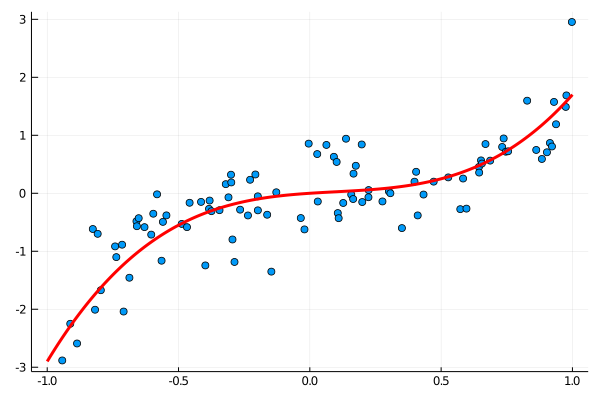

In [3]:
f(x) = 0 + 0.3x -0.6x^2 + 2x^3;
x = sort(rand(Uniform(-1, 1), 100))
y = f.(x) + randn(length(x))*0.5

function plot_data(x, y)
    scatter(x, y, label="data")
    xi = [-1:0.01:1;]
    plot!(xi, f.(xi), label="true", lw=3, color=:red)
    plot!(legend=false)
end

plot_data(x, y)

Determine knot points. We are deciding how many knots to include, but otherwise we are treating the knot locations as fixed parameters.

In [4]:
k = percentile(x, [25, 50, 75])
print(k)

[-0.42510631983692826, 0.029219964272545695, 0.4854924601330771]

## Bayesian inference with the piecewise linear model
First we'll define our piecewise linear model, and then we will plug it into a Turing.jl model. With that, we can calculate the posterior distribution over parameters given the data.

In [5]:
T(x, k) = (x-k)*(x≥k);

In [8]:
function piecewise_linear(β, k, x)
    # left-most region
    y = β[1] + β[2]*x
    # remaining regions
    for i in eachindex(k)
        y += β[i+2] * T(x,k[i])
    end
    return y
end;

Define the Bayesian model

In [9]:
@model function model_linear(x, y, k)
    β ~ filldist(Normal(0, 5), length(k)+2)
    σ ~ truncated(Normal(0, 5), 0, Inf)
    μ = [piecewise_linear(β, k, xi) for xi in x]
    @. y ~ Normal(μ, σ)
end;

<div class="alert alert-block alert-success">
<b>This is extermely cool!</b> All I had to do was specify some priors over the parameters, plug the piecewise function in and specify the likelihood term. This was amazingly easy and I am very impressed being able to do this in Turing.jl. Doing this in PyMC3 would have involved figuring about a bunch of Theano stuff, for example.
</div>

Now run inference

In [10]:
linear_chains = sample(model_linear(x, y, k), NUTS(), MCMCThreads(), 1000, n_chains)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/benjamv/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/Ad

Chains MCMC chain (1000×18×8 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4, 5, 6, 7, 8
Samples per chain = 1000
parameters        = β[1], β[2], β[3], β[4], β[5], σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

        β[1]    1.0791    0.3172     0.0035    0.0057   2634.0368    1.0014
        β[2]    3.1937    0.5024     0.0056    0.0090   2680.3511    1.0015
        β[3]   -2.2603    0.8368     0.0094    0.0152   2573.2108    1.0015
        β[4]   -1.3893    0.8383     0.0094    0.0142   3327.2526    1.0016
        β[5]    3.6172    0.9136     0.0102    0.0152   4015.8920    1.0019
           σ    0.4897 

Visualise the chains

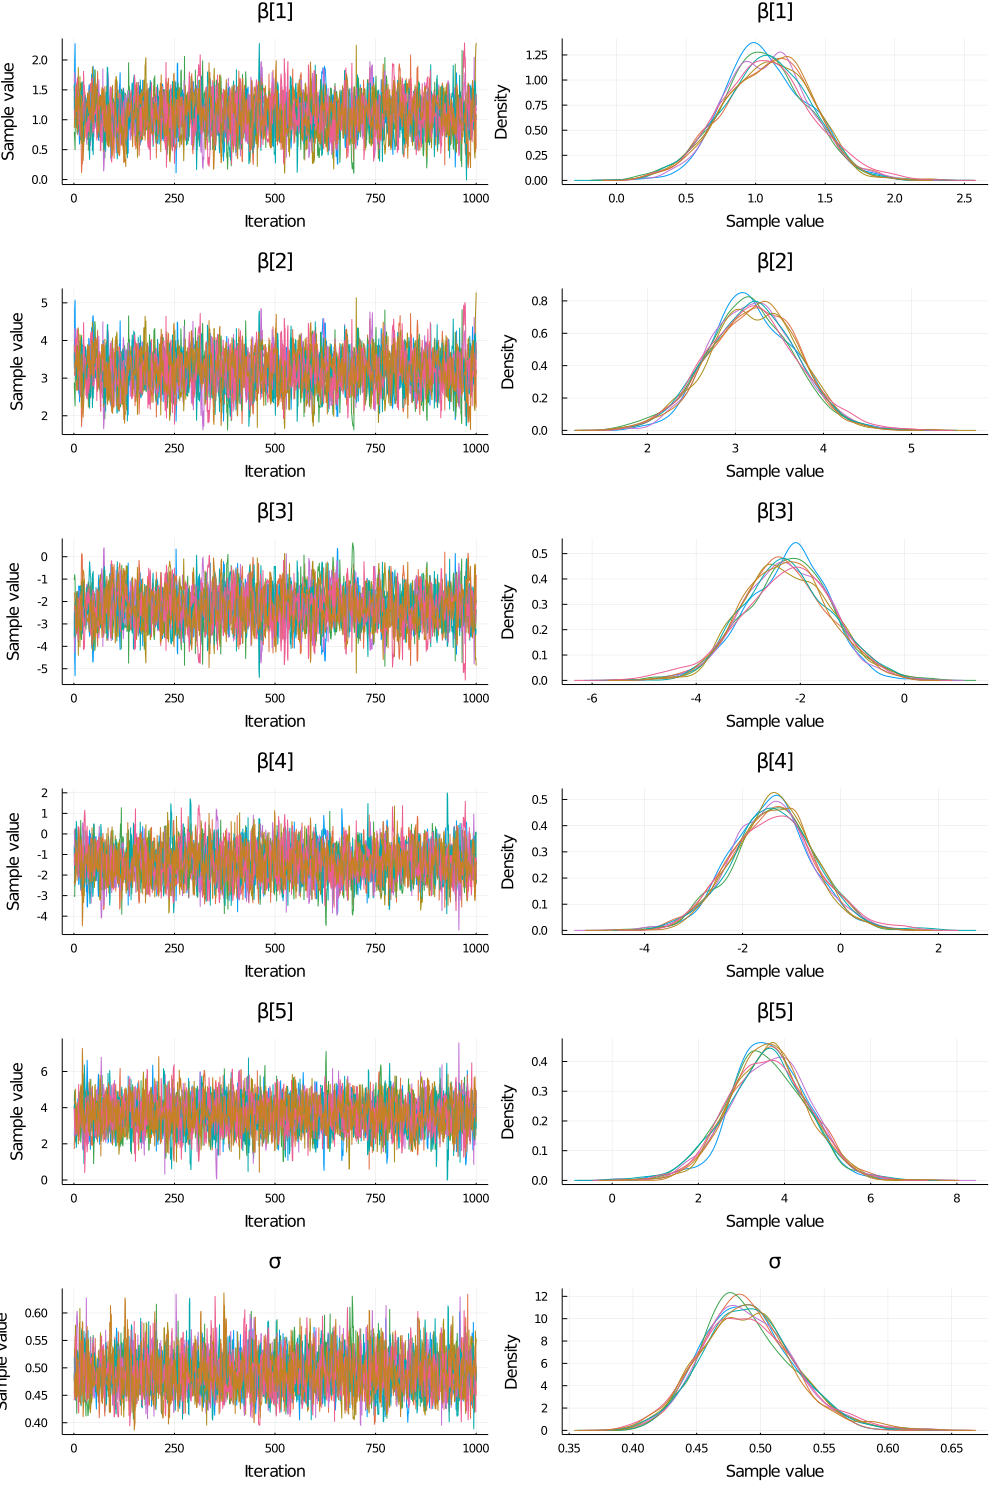

In [11]:
plot(linear_chains)

Now visualise the posterior predictions to see how well the model + parameters account for the data.

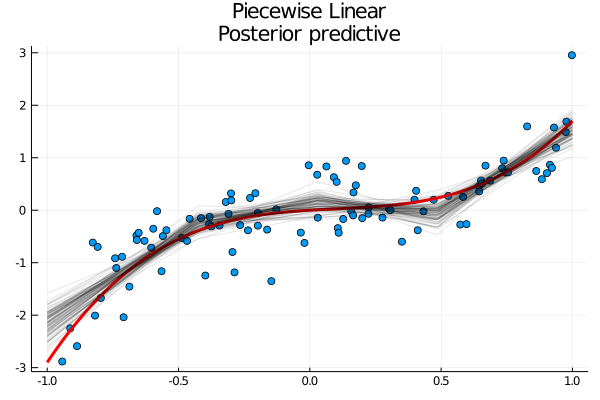

In [15]:
# extract samples and collapse over chains (I know this is not very elegant)
β1 = vec(linear_chains["β[1]"])
β2 = vec(linear_chains["β[2]"])
β3 = vec(linear_chains["β[3]"])
β4 = vec(linear_chains["β[4]"])
β5 = vec(linear_chains["β[5]"])

# plot data ---------------------------------------------------------
plot_data(x, y)

# plot samples from posterior ---------------------------------------
xi = [-1:0.01:1;]
subsamples = 100
ind = rand(1:length(β1), subsamples)
for i in ind
    params = vec([β1[i] β2[i] β3[i] β4[i] β5[i]])
    yi = [piecewise_linear(params, k, x) for x in xi]
    plot!(xi, yi, color=:black, alpha=0.1)
end

# plot posterior predictive mean ------------------------------------
# posterior_mean_params = [mean(β1) mean(β2) mean(β3) mean(β4) mean(β5)]
# yi = [piecewise_linear(posterior_mean_params, k, x) for x in xi]
# plot!(xi, yi, color=:green, lw=3)

plot!(title="Piecewise Linear\nPosterior predictive")

## Bayesian inference with the piecewise cubic model
We will repeat the same steps with the piecewise cubic.

In [16]:
function piecewise_cubic(β, k, x)
    # left-most region
    y = β[1] + β[2]*x + β[3]*x^2 + β[4]*x^3
    # remaining regions
    for i in eachindex(k)
        y += β[i+4] * T(x,k[i])^3
    end
    return y
end

# Note: T() already defined above

piecewise_cubic (generic function with 1 method)

In [17]:
@model function model_cubic(x, y, k)
    β ~ filldist(Normal(0, 5), length(k)+4)
    σ ~ truncated(Normal(0, 5), 0, Inf)
    μ = [piecewise_cubic(β, k, xi) for xi in x]
    @. y ~ Normal(μ, σ)
end

model_cubic (generic function with 1 method)

In [18]:
cubic_chains = sample(model_cubic(x, y, k), NUTS(), MCMCThreads(), 1000, n_chains)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/benjamv/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (tru

Chains MCMC chain (1000×20×8 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4, 5, 6, 7, 8
Samples per chain = 1000
parameters        = β[1], β[2], β[3], β[4], β[5], β[6], β[7], σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

        β[1]    0.1428    0.2339     0.0026    0.0045   2082.0692    1.0020
        β[2]    0.9999    1.5310     0.0171    0.0297   1942.4910    1.0017
        β[3]    1.1005    3.1901     0.0357    0.0615   1963.2467    1.0017
        β[4]    3.0194    2.1380     0.0239    0.0400   2176.3340    1.0016
        β[5]   -1.5188    2.6515     0.0296    0.0521   1903.8651    1.0020
        β[6

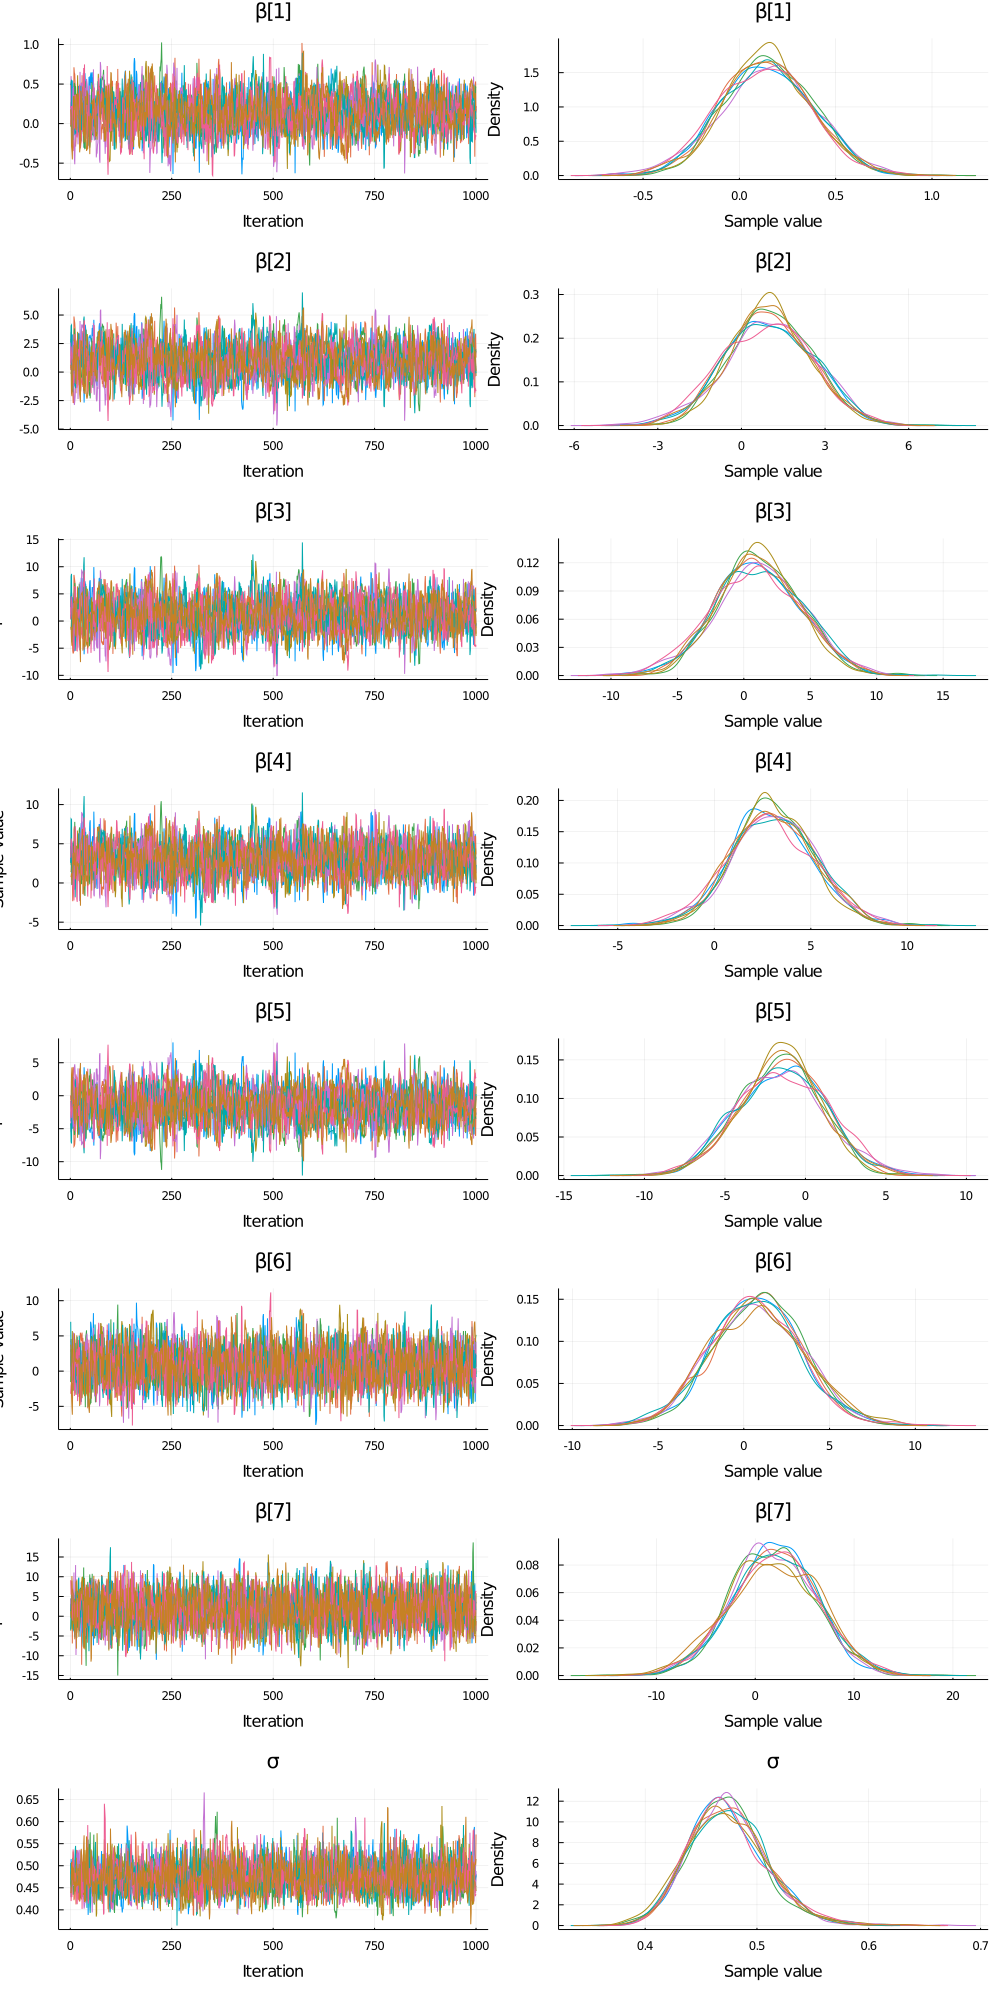

In [19]:
plot(cubic_chains)

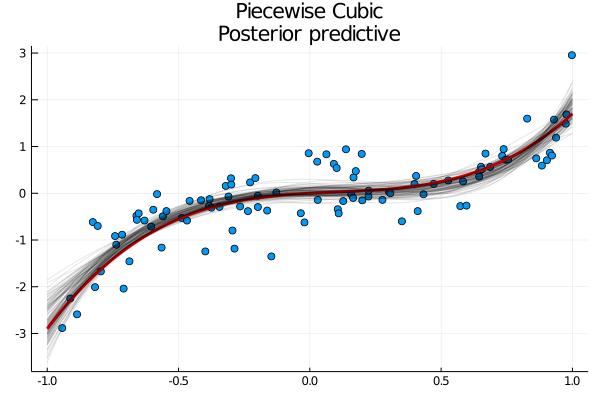

In [20]:
# extract samples and collapse over chains (I know this is not very elegant)
β1 = vec(cubic_chains["β[1]"])
β2 = vec(cubic_chains["β[2]"])
β3 = vec(cubic_chains["β[3]"])
β4 = vec(cubic_chains["β[4]"])
β5 = vec(cubic_chains["β[5]"])
β6 = vec(cubic_chains["β[6]"])
β7 = vec(cubic_chains["β[7]"])

# plot data ---------------------------------------------------------
plot_data(x, y)

# plot samples from posterior ---------------------------------------
xi = [-1:0.01:1;]
subsamples = 100
ind = rand(1:length(β1), subsamples)
for i in ind
    params = vec([β1[i] β2[i] β3[i] β4[i] β5[i] β6[i] β7[i]])
    yi = [piecewise_cubic(params, k, x) for x in xi]
    plot!(xi, yi, color=:black, alpha=0.1)
end

# plot posterior predictive mean ------------------------------------
# posterior_mean_params = [mean(β1) mean(β2) mean(β3) mean(β4) mean(β5)]
# yi = [piecewise_cubic(posterior_mean_params, k, x) for x in xi]
# plot!(xi, yi, color=:green, lw=3)

plot!(title="Piecewise Cubic\nPosterior predictive")

## Summary
While this notebook looks a bit busy with code and plots, conducting Bayesian parameter estimation on the piecewise regression models was incredibly simple and elegant. I was _very_ impressed that you could just take an arbitray Julia function and plug it into a Turing.jl model and run inference. The core work being done here boils down to just the following code:

```julia
function piecewise_cubic(β, k, x)
    y = β[1] + β[2]*x + β[3]*x^2 + β[4]*x^3
    for i in eachindex(k)
        y += β[i+4] * T(x,k[i])^3
    end
    return y
end

T(x, k) = (x-k)*(x≥k);

@model function model_cubic(x, y, k)
    β ~ filldist(Normal(0, 5), length(k)+4)
    σ ~ truncated(Normal(0, 5), 0, Inf)
    μ = [piecewise_cubic(β, k, xi) for xi in x]
    @. y ~ Normal(μ, σ)
end

# Load x, y data
# Run inference
# Examine chains and do something with the parameter estimates
```

So this is very nice in terms of being able to express your models simply and efficiently. Not having to spend a lot of time on contortions that the PPL modelling language demands of you, lets you get work done more efficiently, and frees you up to think about the modelling more. 